Copied from ``BEM_fit_nanrod_in_vacuum__012419-Copy1`` on 02/07/29

This file computes 

In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import yaml

import numpy as np
import scipy.optimize as opt
from scipy import interpolate
import scipy.io as sio
import scipy.special as spf

## import diffrantion integral solver from Optics folder
project_path = ('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/'
    +
    'Mispolarization/python/gitted'
    )
optics_path = project_path + '/Optics'
sys.path.append(optics_path)
# sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib

## Read parameter file to obtain physical properties 
## of molecule and plasmon, molecule and imaging system.
parameter_files_path = (
    project_path + '/parameter_files'
)

curly_yaml_file_name = '/curly_nrod_vacuum.yaml'
parameters = yaml.load(open(parameter_files_path+curly_yaml_file_name,'r'))


modules_path = project_path + '/solving_problems/modules'
sys.path.append(modules_path)

import fitting_misLocalization as fit

## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
get_ipython().magic('matplotlib inline')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

## Import analytic expressions for the focused fields from a point dipole.
import anal_foc_diff_fields as afi

## Import computational solution to two coupled oscillators of arbitrarty 
## anisotropic polarizabilities. 
# import coupled_dipoles as cp 

## Import physical constants from yaml file.
phys_const_file_name = '/physical_constants.yaml'
opened_constant_file = open(
    parameter_files_path+phys_const_file_name,
    'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## Define some useful constants from defined parameters
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.
# a = parameters['plasmon']['radius']



#######################################################################
## Optics stuff.  
sensor_size = parameters['optics']['sensor_size']*nm
# height = 2*mm  # also defines objective lens focal length 
# height = parameters['optics']['obj_f_len']
resolution = parameters['optics']['sensor_pts']  # image grid resolution
## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = parameters['optics']['magnification']
numerical_aperture = parameters['optics']['numerical_aperture']
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = parameters['optics']['lens_points']

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = parameters['optics']['obj_f_len']

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = parameters['general']['drive_energy'] ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_vacuum.yaml
reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_vacuum.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


# initialize matlab stuff

In [2]:
## import matlab engine to run BEM
import matlab
import matlab.engine

variable_dict = {'list_of_coodinates':eye[0]/nm, 'meshed_X':eye[1]/nm,'meshed_Y':eye[2]/nm}


In [3]:
## values required for scattered field calculation of sphere
sphere_points = fib.fib_alg_k_filter(
    num_points=lens_points, 
    max_ang=max_theta
    )

cart_points_on_sph = fib.sphere_to_cart(
    sphere_points[:,0],
    sphere_points[:,1],
    obj_f*np.ones(np.shape(sphere_points[:,0]))
    )

given even number of points for Fibonacci lattice, 
  adding 1...


In [4]:
## start matlab before looping
print('starting Matlab...')
eng = matlab.engine.start_matlab()

## convert lens-integration coordinates to matlab variable
matlab_cart_points_on_sph = matlab.double(cart_points_on_sph.tolist())

starting Matlab...


In [5]:
mol_location = [100,0,0]

In [6]:
def fixed_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 3, mol_angle=0):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
#     random_mol_angles= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, mol_angle]

In [7]:
class Simulation(object):
    """Runs BEM simulation
    
    Collects focused+diffracted far-field information from molecules nearby a nanorod 
    by MNPBEM calculation in an invisible instance of Matlab.
    
    Args:
        locations: list of 3D cartesien coordinates of molecules. 
            One simulation is run per location.  
        mol_angle: Angle on the molecule's dipole moment relatice to the x-axis
        plas_angle: Angle of the long-axis of the nanorod relative to the x-axis
    
    Attributes:
        mol_too_close: named confusingly, this method is built to filter locations
            for points within the fluorescence quenching region around the nanorod, 
            assigned to be 10 nm from the surface of the fit ellipsoid.
            Returns: VALID locations OUTSIDE this region.
        calculate_BEM_fields: runs simulatins and stores results in attributes; 
            bem_E: Focused and diffracted electric field
            BEM_images: 
    
    """
    
    ## set up inverse mapping from observed -> true angle for signle molecule in the plane. 
        
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2
                 ):
        self.n_b = np.sqrt(1.778) ## Curly's water 
        self.mol_locations = locations
        self.mol_angles = mol_angle
        self.rod_angle = plas_angle
        
        #### Filtering out molecules in region of fluorescence quenching 
        self.el_a = parameters['plasmon']['fit_a1'] ## ranorod degenerate radius
        self.el_c = parameters['plasmon']['fit_a2']
        self.quel_a = self.el_a + 10 ## define quenching region
        self.quel_c = self.el_c + 10
        self.input_x_mol = locations[:,0]
        self.input_y_mol = locations[:,1]
        
        self.pt_is_in_ellip = self.mol_too_close()
        ## select molecules outside region,
        self.mol_locations = locations[self.pt_is_in_ellip]
        ## select molecule angles if listed per molecule, 
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            self.mol_angles = mol_angle[self.pt_is_in_ellip]
        else: self.mol_angles = mol_angle

        self.default_plot_limits = [
            np.min(self.mol_locations)-((np.max(self.mol_locations)-np.min(self.mol_locations))*.1),
            np.max(self.mol_locations)+((np.max(self.mol_locations)-np.min(self.mol_locations))*.1)]
        
    def mol_too_close(self):
        '''Returns molecule locations that are outside the fluorescence quenching zone,
            defined as 10 nm from surface of fit spheroid'''
        rotated_x = np.cos(self.rod_angle)*self.input_x_mol + np.sin(self.rod_angle)*self.input_y_mol
        rotated_y = -np.sin(self.rod_angle)*self.input_x_mol + np.cos(self.rod_angle)*self.input_y_mol
        long_quench_radius = self.quel_a
        short_quench_radius = self.quel_c
        rotated_ellip_eq = rotated_x**2./long_quench_radius**2 + rotated_y**2./short_quench_radius**2
        return (rotated_ellip_eq > 1)
        
    def calculate_BEM_fields(self):
        """ Runs BEM simulation in Matlab using parameters initialized parameters 
            """
        if hasattr(self, 'BEM_images'):
            return self.BEM_images
            
        mol_locations = self.mol_locations
        mol_angle = self.mol_angles
        drive_energy = drive_hbar_omega
        
        number_of_molecules = mol_locations.shape[0]

        self.BEM_images = np.zeros((number_of_molecules, eye[0].shape[0]))
        self.bem_E = np.zeros((number_of_molecules, eye[0].shape[0], 3))
        
        for i in range(number_of_molecules):
            print('{}th molecule'.format(int(i+1)))
            mol_location = mol_locations[i]
            mol_orientation = [np.cos(mol_angle), np.sin(mol_angle), 0]

            [E, sph_p] = eng.BEM_CurlyNanRod_dipDrive_E(
                matlab.double(list(mol_location)), 
                drive_energy, 
                matlab.double(list(mol_orientation)), 
                matlab_cart_points_on_sph,
                float(self.n_b**2.),
                nargout=2)


            BEM_scattered_E = np.asarray(E)
                # print('BEM_scattered_E.shape = ',BEM_scattered_E.shape)
                # BEM_scattered_H = np.asarray(H)
                # print('BEM_scattered_H.shape = ',BEM_scattered_H.shape)
            cart_sphere_points = np.asarray(sph_p)

            sph_sph_points = fib.cart_to_sphere(
                cart_sphere_points[:,0],
                cart_sphere_points[:,1],
                cart_sphere_points[:,2]
                ).T

            thetas_and_phis = sph_sph_points[:,1:]

            print(
                'calculating diffracted fields')
            
            diffracted_E_field = diffi.perform_integral(
                scattered_E=BEM_scattered_E, 
                scattered_sph_coords=thetas_and_phis, 
                obser_pts=eye[0]*np.array([[1,-1]]), 
                z=0, 
                obj_f=obj_f, 
                tube_f=tube_f, 
                k=omega_drive*self.n_b/c,
                alpha_1_max=max_theta
                )

            diffracted_power_flux = np.real(
                np.sum(
                    np.multiply(diffracted_E_field,
                        np.conj(diffracted_E_field)
                        ),
                    axis=-1
                    )
                )

            self.bem_E[i] = diffracted_E_field
            self.BEM_images[i] = diffracted_power_flux
        return self.BEM_images

### Wrap Simulation class into an object with same attributes as MolCoupNanoRodExp, so that the Gaussian Localization can be calculated

In [8]:
class SimulatedExperiment(Simulation,fit.MolCoupNanoRodExp):        
    """
        
        """
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2, 
                 obs_points=None,):
        
        fit.CoupledDipoles.__init__(self, obs_points)
        
        self.n_b = np.sqrt(1.778) ## Curly's water 
        ###### from fit.MolCoupNanoRodExp
        self.mol_locations = locations
        self.mol_angles = mol_angle
        self.rod_angle = plas_angle
        
        #### Filtering out molecules in region of fluorescence quenching 
        self.el_a = parameters['plasmon']['fit_a1'] ## ranorod degenerate radius
        self.el_c = parameters['plasmon']['fit_a2']
        self.quel_a = self.el_a + 10 ## define quenching region
        self.quel_c = self.el_c + 10
        self.input_x_mol = locations[:,0]
        self.input_y_mol = locations[:,1]

        self.pt_is_in_ellip = self.mol_too_close()
        ## select molecules outside region,
        self.mol_locations = locations[self.pt_is_in_ellip]
        ## select molecule angles if listed per molecule, 
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            self.mol_angles = mol_angle[self.pt_is_in_ellip]
        else: self.mol_angles = mol_angle

        ##Features cut out of Model experiment calss for simulation class
#         (self.mol_E, 
#          self.plas_E, 
#          self.p0_unc_E, 
#          self.p0, 
#          self.p1) = self.dipole_fields(self.mol_locations, self.mol_angles, self.rod_angle)

#         self.trial_images = self.calculate_BEM_fields()

        self.default_plot_limits = [
            np.min(self.mol_locations)-((np.max(self.mol_locations)-np.min(self.mol_locations))*.1),
            np.max(self.mol_locations)+((np.max(self.mol_locations)-np.min(self.mol_locations))*.1)]
        
    

In [14]:
locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=10, x_max=300, y_max=300)

In [15]:
simTestInst = SimulatedExperiment(locations, mol_angle=np.pi/2)

In [16]:
simTestInst.trial_images = simTestInst.calculate_BEM_fields()

1th molecule
calculating diffracted fields


/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:129: ComplexWarning: Casting complex values to real discards the imaginary part


2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields
22th molecule
calculating diffracted fields
23th molecule
calculating diffracted fields
24th molecule
calculating diffracted fie

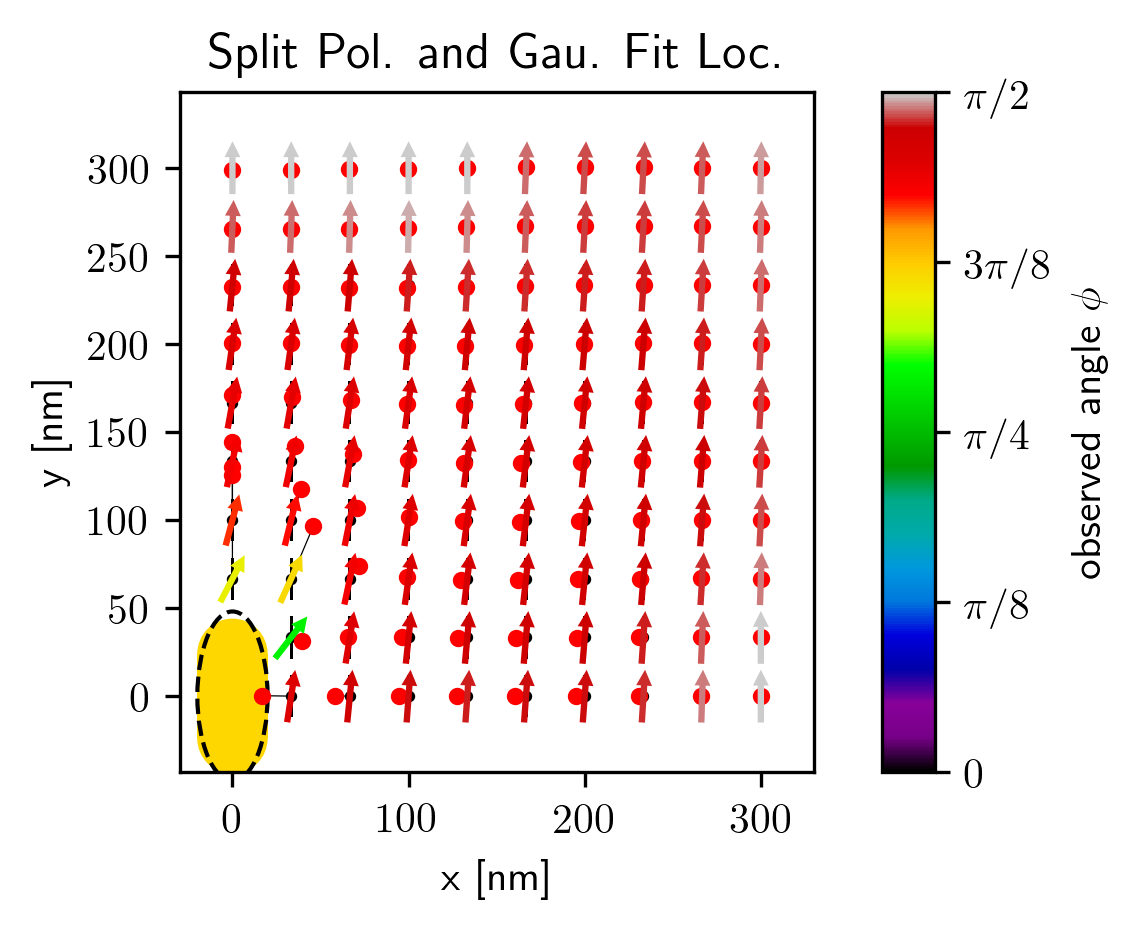

In [17]:
simTestInst.plot_mispol_map_wMisloc()

Compare to model fit.

In [ ]:
# import fitting_misLocalization_adding_noise_to_modeled_images__011619v11 as fit

In [13]:
test_BEM_fit_instance = fit.FitModelToData(simTestInst.BEM_images)
test_BEM_fit_instance.fit_model_to_image_data()
# test_BEM_fit_instance.plot_contour_fit_over_data(0)

initial guess for molecule 0 location: (-10.0,131.0)


/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/solving_problems/modules/coupled_dipoles.py:203: RuntimeWarning: divide by zero encountered in arctanh
  L = (1-e**2.)/e**3. * (-e + np.arctanh(e))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/solving_problems/modules/coupled_dipoles.py:203: RuntimeWarning: invalid value encountered in double_scalars
  L = (1-e**2.)/e**3. * (-e + np.arctanh(e))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/solving_problems/modules/coupled_dipoles.py:245: RuntimeWarning: divide by zero encountered in double_scalars
  ((1+e**2.)/(1-e**2.))*L_i(1, a_x, a_yz) + 1
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/solving_problems/modules/coupled_dipoles.py:252: RuntimeWarning: divide by zero encountered in arctanh
  D = (a_yz/(2*a_x))*(3/e * np.arctanh(e) - D_x(a_x,a_yz))
/Users/chair/anaconda/envs/py36/lib/python3.

ValueError: Residuals are not finite in the initial point.

In [ ]:
test_BEM_fit_instance.plot_fit_results_as_quiver_map(simTestInst)   

In [ ]:
locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=300, y_max=300)
simTestInst_few_mol = SimulatedExperiment(locations, mol_angle=np.pi/2)
simTestInst_few_mol.trial_images = simTestInst_few_mol.calculate_BEM_fields()

In [ ]:
simTestInst_few_mol.plot_mispol_map_wMisloc()

In [ ]:
test_BEM_fit_instance_few_mol = fit.FitModelToData(simTestInst_few_mol.BEM_images)
test_BEM_fit_few_mol = test_BEM_fit_instance_few_mol.fit_model_to_image_data()
# test_BEM_fit_instance.plot_contour_fit_over_data(0)

In [ ]:
test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(simTestInst_few_mol)   

In [ ]:
locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=7, x_max=300, y_max=300)
simTestInst_few_more_mol = SimulatedExperiment(locations, mol_angle=np.pi/2)
simTestInst_few_more_mol.trial_images = simTestInst_few_more_mol.calculate_BEM_fields()

In [ ]:
simTestInst_few_more_mol.plot_mispol_map_wMisloc()

In [ ]:
test_BEM_fit_instance_few_more_mol = fit.FitModelToData(simTestInst_few_more_mol.BEM_images)
test_BEM_fit_few_more_mol = test_BEM_fit_instance_few_more_mol.fit_model_to_image_data()
test_BEM_fit_instance_few_more_mol.plot_fit_results_as_quiver_map(simTestInst_few_more_mol)   

In [ ]:
test_BEM_fit_instance.model_fit_results

In [ ]:
# test_BEM_fit_instance.model_fit_results = test_BEM_fit_instance.model_fit_results*np.array([[1,-1,1]])

In [ ]:
test_BEM_fit_instance.plot_fit_results_as_quiver_map(simTestInst)  

In [ ]:
simTestInst_yMol = SimulatedExperiment(locations, mol_angle=0)
simTestInst_yMol.plot_mispol_map_wMisloc()

test_BEM_fit_instance_yMol = fit.FitModelToData(simTestInst_yMol.BEM_images)
test_BEM_fit_yMol = test_BEM_fit_instance_yMol.fit_model_to_image_data()
# test_BEM_fit_instance.plot_contour_fit_over_data(0)

# test_BEM_fit_instance_yMol.model_fit_results = test_BEM_fit_instance_yMol.model_fit_results*np.array([[1,-1,1]])
test_BEM_fit_instance_yMol.plot_fit_results_as_quiver_map(simTestInst_yMol)

Seems to be working now, but not much better than the gaussian fits at this point. Arguably worse locatization, polarization seems significantly better but that could be due to the correct initial guess. 

## Time to try and fit Curly's images. Should be able to feed the data into 'FitModelToData' after first loading the data in from the matlab files.

In [ ]:
import scipy.io as sio

In [ ]:
mol_img_y_700_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/mol_img_y_700.mat')

In [ ]:
mol_img_y_700 = mol_img_y_700_file['mol_img_y_700']

In [ ]:
mol_img_y_700.shape

In [ ]:
simTestInst_yMol.BEM_images.shape

Need to reshape Curly's data to match the BEM_images shape I have been using. 

In [ ]:
reshaped_Curly_image_y_700nm = mol_img_y_700.reshape((99, 300*300))

In [ ]:
reshaped_Curly_image_y_700nm.shape

need to load in Curly's x and y coordinates and modify the 'FitModelToData' to accept coordinates different from 'eye' default. But first, lunch.

In [ ]:
x_image_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/x_image.mat')
y_image_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/y_image.mat')
true_position_file = sio.loadmat('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/Curly_simulated_images_nrod_mol_downloaded_010818/true_position.mat')

In [ ]:
curly_x_space = x_image_file['x_image'][:, 0]
curly_y_space = y_image_file['y_image'][:, 0]

In [ ]:
true_position_file['true_pos'].shape

In [ ]:
Curly_true_position = np.hstack((true_position_file['true_pos'], np.zeros((99,1))))

In [ ]:
class FitModelToCurlyData(fit.FitModelToData):
    """Should do the same thing as FitModelToData Except handle 
        Curly's grid of observation points 
    
    Args:
        image_data: same as super
        obs_coords: Meshgrid of Curly's points
        
    Attributes:
        default_plot_limits:
        mol_locations:
        mol_angles:
        rod_angle:
        
    """
    pass

Really I should build an Exp class for Curly's stuff, so the true positions are accessable to plotting functions

I can actually do this with 'Simulation'

In [ ]:
class SimulatedCurlyExperiment():
    

In [ ]:
Curly_X, Curly_Y = np.meshgrid(curly_x_space, curly_y_space)
Curly_Simultation = SimulatedExperiment(locations=Curly_true_position,x_obv_grid=Curly_X, y_obv_grid=Curly_Y)


need a new class that doesnt automatically run BEM calculations. JK just commented out the line in Simulation.\__init\__ that ran the BEM calculations and stored the results as self.BEM_images

In [ ]:
class FitModelToAnyData(fit.FitModelToData):
    
    def __init__(self, image_data, 
                 x_obv_grid=eye[1],
                 y_obv_grid=eye[2]):
        
        self.mol_angle=0 
        self.rod_angle=np.pi/2

        self.x_obv_grid=x_obv_grid
        self.y_obv_grid=y_obv_grid
        
        self.image_data = image_data

In [ ]:
Fit_Curly_images = FitModelToAnyData(reshaped_Curly_image_y_700nm, Curly_X, Curly_Y)

In [ ]:
Fit_Curly_images.plot_fit_results_as_quiver_map(Curly_Simultation)